# 1.**Processo inicial**

In [47]:
# Bibliotecas
import numpy as np
import pandas as pd

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas do scikit-learn para pré-processamento, modelagem e avaliação
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

# Modelos de Regressão que poderemos testar
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



# Motivo das bibliotecas escolhidas.

numpy, pandas: estruturas de dados e operações matemáticas essenciais.

matplotlib, seaborn: criação de gráficos e plotagens para análise exploratória (EDA).

scikit-learn: oferece um framework unificado para pré-processamento.

RandomForestRegressor, GradientBoostingRegressor: modelos de árvores populares para regressão.

In [3]:
# Montagem do Google Drive para acesso a BASE de dados.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.**Carregamento dos Dados**

Nesta etapa, realizamos a importação do dataset que será utilizado.

1. Verificamos o tamanho do dataset (número de linhas e colunas), para termos uma ideia inicial de quantos registros e variáveis possuímos.

2. Conferimos amostras iniciais dos dados (`df.head()`), para garantir que o carregamento foi bem-sucedido e que as colunas fazem sentido, de acordo com o dicionário fornecido.

3. Examinamos informações como tipos de dados (`df.info()`) e valores nulos (`df.isnull().sum()`), pois isso nos ajuda a planejar eventuais tratamentos de dados (por exemplo, imputação de valores ausentes ou conversão de tipos).


In [12]:
# Substitua o nome do arquivo pelo correto, caso seja diferente
df = pd.read_csv("/content/drive/MyDrive/Indicium/teste_indicium_precificacao.csv")

# Verificando dimensões do DataFrame
print("Dimensões do dataset (linhas x colunas):", df.shape)

# Visualizando as primeiras linhas
df.head()

# Observando detalhes sobre os tipos de cada coluna
df.info()

# Quantificando valores nulos em cada coluna
df.isnull().sum()


Dimensões do dataset (linhas x colunas): (48894, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64 

,0
id,0
nome,16
host_id,0
host_name,21
bairro_group,0
bairro,0
latitude,0
longitude,0
room_type,0
price,0


# **3. Análise Exploratória de Dados (EDA)**

Nesta seção, examinaremos:

1. **Estatísticas descritivas** das colunas numéricas, como `price`, `minimo_noites`, `numero_de_reviews`, entre outras.

2. **Distribuição** da variável-alvo (`price`) para entender a presença de outliers ou forte assimetria.

3. **Relações** entre colunas chave (ex.: `price` vs. `disponibilidade_365`) e variáveis categóricas (ex.: `bairro_group`, `room_type`).

4. **Validação** das perguntas do desafio de negócio, como:
   - Onde seria mais indicada a compra de um apartamento?

   - Se `minimo_noites` e `disponibilidade_365` interferem no preço.

   - E se existe algum padrão no texto do `nome` associado a locais de alto valor.



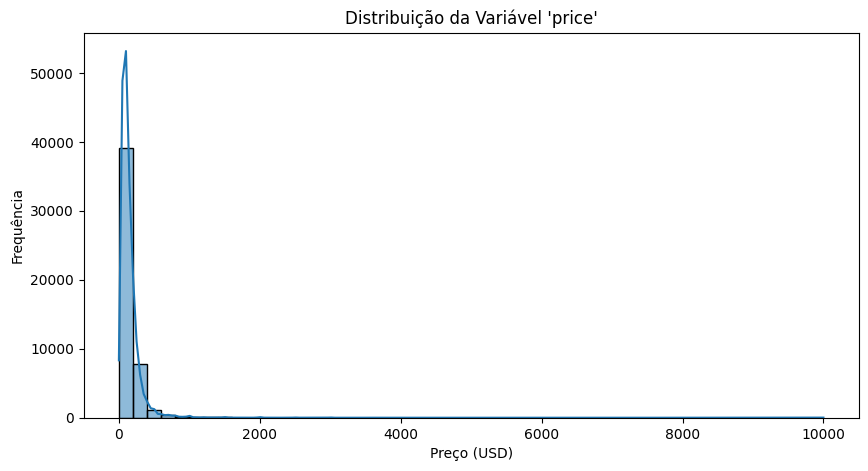


Valores únicos em 'bairro_group': ['Manhattan' 'Brooklyn' 'Queens' 'Staten Island' 'Bronx']
Valores únicos em 'room_type': ['Entire home/apt' 'Private room' 'Shared room']


In [11]:
# Visualizando estatísticas descritivas de colunas numéricas
df.describe(include='all')

# Exemplo de distribuição do 'price'
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribuição da Variável 'price'")
plt.xlabel("Preço (USD)")
plt.ylabel("Frequência")
plt.show()

# Podemos também verificar a contagem de valores únicos em colunas categóricas
print("\nValores únicos em 'bairro_group':", df['bairro_group'].unique())
print("Valores únicos em 'room_type':", df['room_type'].unique())


Com base no gráfico acima, podemos ver que a maioria dos preços está concentrada na faixa de 0 a 200 dólares. No entanto, há alguns valores atípicos que se destacam, com preços muito altos, chegando até 10.000 dólares.

## Boxplots e Outliers

Para verificar a concentração de preços em cada grupo (como bairros e tipos de quarto), vamos construir boxplots. Dessa forma, podemos identificar a presença de outliers com mais clareza e visualizar a mediana, quartis e dispersão do `price`.

### - `price` por Bairros (`bairro_group`)

Examinamos se alguns bairros têm faixas de preços muito distintas e levantamos hipóteses sobre por que isso pode ocorrer (por exemplo, Manhattan tende a ser mais caro por ser região central/turística).

### - `price` por Tipo de Quarto (`room_type`)

Vemos se “Entire home/apt” é consistentemente mais caro do que “Private room” ou “Shared room”.


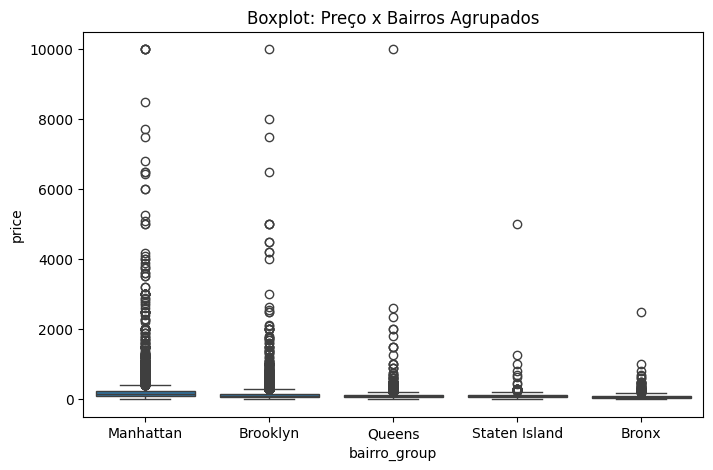

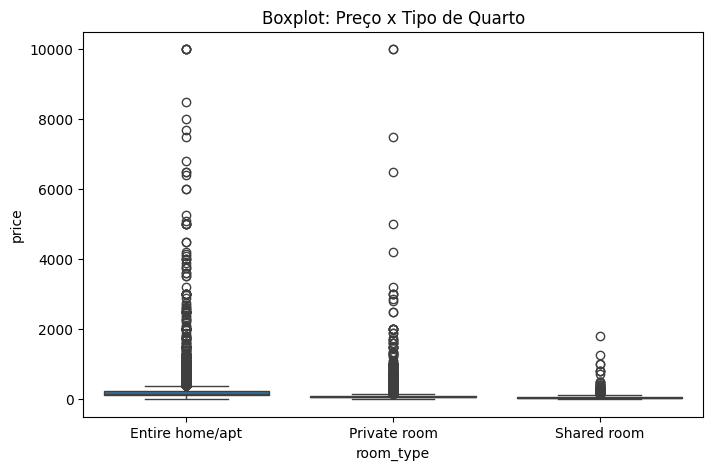

In [13]:
# Boxplot: Preço vs. Bairros
plt.figure(figsize=(8,5))
sns.boxplot(x='bairro_group', y='price', data=df)
plt.title("Boxplot: Preço x Bairros Agrupados")
plt.show()

# Boxplot: Preço vs. Tipo de Quarto
plt.figure(figsize=(8,5))
sns.boxplot(x='room_type', y='price', data=df)
plt.title("Boxplot: Preço x Tipo de Quarto")
plt.show()


Com base nos gráficos acima, observamos que Manhattan e Brooklyn concentram a maior parte dos valores atípicos, com preços extremamente altos. Por outro lado, Staten Island e o Bronx tendem a ter preços mais baixos, em média.

Quando analisamos as categorias de acomodação, os imóveis do tipo "Casa/Apartamento inteiro" apresentam uma grande variação de preços, com vários valores ultrapassando mil dólares. Já os quartos compartilhados costumam ser mais acessíveis, com preços geralmente mais baixos.

## Correlação Entre Variáveis Numéricas

Nesta subseção, vamos verificar se existe correlação linear significativa entre o `price` e outras variáveis numéricas, como:
- `minimo_noites`
- `numero_de_reviews`
- `reviews_por_mes`
- `disponibilidade_365`
- `calculado_host_listings_count`



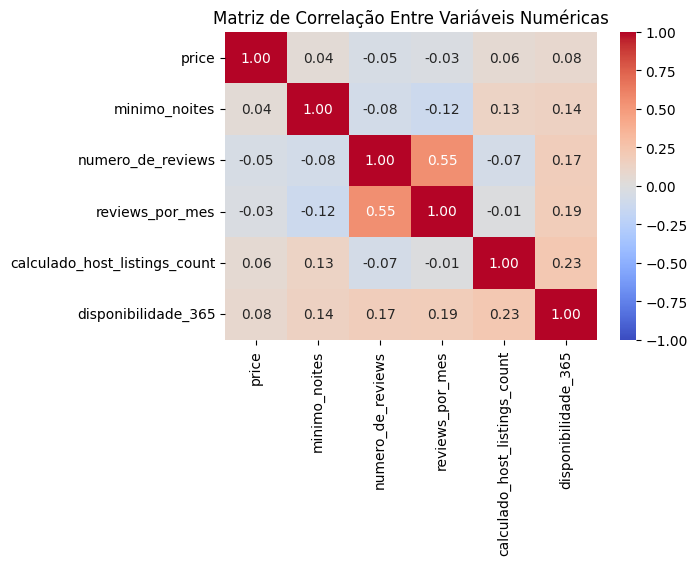

In [14]:
# Lista de colunas numéricas que nos interessam (excluindo colunas ID)
num_cols = [
    'price',
    'minimo_noites',
    'numero_de_reviews',
    'reviews_por_mes',
    'calculado_host_listings_count',
    'disponibilidade_365'
]

# Criando a matriz de correlação
corr = df[num_cols].corr()

# Plotando um heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Matriz de Correlação Entre Variáveis Numéricas")
plt.show()


A matriz de correlação que analisamos mostra que o preço não tem uma relação forte com as variáveis numéricas que escolhemos.
As correlações com mínimo de noites, número de reviews, reviews por mês, contagem de listagens do host e disponibilidade de 365 dias são todas muito fracas, variando entre -0,05 e 0,08.
Isso não significa que não possam existir relações diferentes, mas indica que, se houver algum efeito, ele não é capturado apenas por essa análise.

Disponibilidade de 365 dias (0,08) e contagem de listagens do host (0,06) têm as correlações mais altas com o preço, sugerindo que anúncios mais caros podem ficar disponíveis por mais tempo ou pertencer a hosts com mais listagens. No entanto, essa relação ainda é fraca.

O mínimo de noites (0,04) quase não se relaciona com o preço.

O número de reviews (-0,05) e reviews por mês (-0,03) mostram uma correlação negativa fraca, o que pode indicar que anúncios mais caros não necessariamente recebem menos ou mais reviews de forma linear.

## Analisando 'minimo_noites' e 'disponibilidade_365' em relação ao 'price'

Precisamos verificar se o número mínimo de noites e a disponibilidade anual afetam o preço do imóvel.


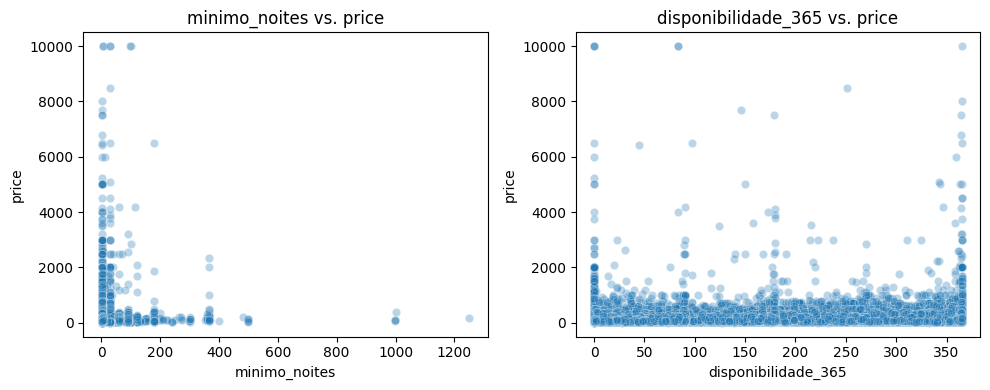

In [15]:
plt.figure(figsize=(10,4))

# Scatter de minimo_noites vs price
plt.subplot(1,2,1)
sns.scatterplot(x='minimo_noites', y='price', data=df, alpha=0.3)
plt.title("minimo_noites vs. price")

# Scatter de disponibilidade_365 vs price
plt.subplot(1,2,2)
sns.scatterplot(x='disponibilidade_365', y='price', data=df, alpha=0.3)
plt.title("disponibilidade_365 vs. price")

plt.tight_layout()
plt.show()


A análise dos gráficos de dispersão confirma o que já havíamos observado na matriz de correlação: não há um padrão linear forte entre o preço e essas duas variáveis. Vamos aos detalhes:

Mínimo de noites vs. Preço
A maior concentração de pontos está em valores baixos de mínimo de noites (até 30 ou 50 noites) e preços de até $500.

Há alguns valores extremos para mínimo de noites muito altos (acima de 400, 800 ou até 1200 noites), com preços que variam bastante, sem um padrão claro.

Também vemos imóveis com preços próximos a $10.000 mesmo com mínimo de noites muito baixo (1 ou 2 noites), o que sugere que podem ser imóveis de luxo.

Disponibilidade de 365 dias vs. Preço
Há uma dispersão significativa: imóveis com poucos dias disponíveis e outros com quase 365 dias variam de preços muito baixos a muito altos.

Não há indicação de que imóveis com maior disponibilidade (ex.: acima de 300 dias) sejam sistematicamente mais caros ou mais baratos.

É comum ver preços altos (acima de $2000) espalhados por toda a faixa de disponibilidade, reforçando a ausência de uma correlação linear clara.

Em resumo, os gráficos mostram que não há uma relação linear forte entre o preço e essas variáveis, confirmando a análise anterior.

## Análise Agregada por Bairro

- **Preço médio** ou mediano por bairro (`bairro_group`)
- **Número médio de reviews** (pode refletir interesse ou popularidade)
- **Disponibilidade média** ao longo do ano



In [16]:
# Exemplo de agrupamento por bairro_group
agg_bairros = df.groupby('bairro_group').agg(
    media_preco=('price','mean'),
    mediana_preco=('price','median'),
    media_reviews=('numero_de_reviews','mean'),
    media_disp=('disponibilidade_365','mean'),
    count_listings=('id','count')
).reset_index()

# Ordenando por média de preço (descendente)
agg_bairros.sort_values('media_preco', ascending=False, inplace=True)
agg_bairros


,bairro_group,media_preco,mediana_preco,media_reviews,media_disp,count_listings
2,Manhattan,196.875814,150.0,20.985596,111.979410,21661
1,Brooklyn,124.381983,90.0,24.203601,100.219122,20103
4,Staten Island,114.812332,75.0,30.941019,199.678284,373
3,Queens,99.517649,75.0,27.700318,144.451818,5666
0,Bronx,87.496792,65.0,26.004583,165.758937,1091


##Mínimo de noites vs. Preço
A maior parte dos pontos se concentra em valores baixos de mínimo de noites (até 30 ou 50 noites) e preços de até 500 Dólares.
 No entanto, há alguns casos extremos, com mínimo de noites muito altos (acima de 400, 800 ou até 1200 noites), onde os preços variam bastante, sem um padrão definido. Além disso, observamos imóveis com preços próximos a 10.000 Dólares, mesmo com mínimo de noites muito baixo (1 ou 2 noites), o que sugere que podem ser propriedades de luxo.

##Disponibilidade de 365 dias vs. Preço
Aqui, a dispersão é bastante significativa. Imóveis com poucos dias disponíveis e outros com quase 365 dias apresentam preços que variam de muito baixos a muito altos. Não há indícios de que imóveis com maior disponibilidade (por exemplo, acima de 300 dias) sejam sistematicamente mais caros ou mais baratos. É comum encontrar preços altos (acima de 2000 Dólares) distribuídos por toda a faixa de disponibilidade, o que reforça a ausência de uma correlação linear clara.

# **4. Limpeza e Preparação dos Dados para Modelagem**



In [17]:
#Verificação de nulos
df.isnull().sum()


,0
id,0
nome,16
host_id,0
host_name,21
bairro_group,0
bairro,0
latitude,0
longitude,0
room_type,0
price,0


Nulos após tratamento:
id                                0
nome                              0
host_id                           0
host_name                        21
bairro_group                      0
bairro                            0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimo_noites                     0
numero_de_reviews                 0
reviews_por_mes                   0
calculado_host_listings_count     0
disponibilidade_365               0
dtype: int64


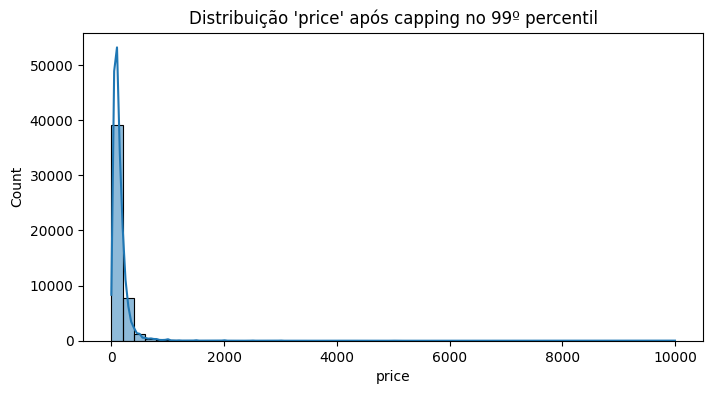

,nome,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
1,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
2,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
3,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
4,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129


In [18]:
# =======================================
# 1) TRATAMENTO DE VALORES NULOS
# =======================================

# 1.1) 'nome': Preencher com string vazia
df['nome'] = df['nome'].fillna("")

# 1.2) 'reviews_por_mes': onde nulo, assumimos 0 (sem reviews)
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)

# 1.3) 'ultima_review': se não vamos usar como feature, removemos
df.drop(columns=['ultima_review'], inplace=True)

# Verificando se ainda restam nulos
print("Nulos após tratamento:")
print(df.isnull().sum())

# =======================================
# 2) REMOÇÃO DE COLUNAS IRRELEVANTES
# =======================================

cols_to_drop = ['id', 'host_id', 'host_name']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# =========================================
# 3) VERIFICAÇÃO FINAL
# =========================================

# Conferir a distribuição de 'price' após o cap
plt.figure(figsize=(8,4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribuição 'price' após capping no 99º percentil")
plt.show()

df.head()

# 1. Criação de Feature “Luxo”

In [19]:

df['nome_lower'] = df['nome'].str.lower()
df['tem_luxury'] = df['nome_lower'].str.contains('luxury|penthouse|deluxe|loft').astype(int)

# Agora, 'tem_luxury' é 1 se aparecer algum termo, caso contrário 0.
# Verificamos a média de preço, só para ter uma ideia:
df.groupby('tem_luxury')['price'].mean()


,price
tem_luxury,
0,144.234062
1,241.823142


#2. Codificação de Variáveis Categóricas

In [20]:
#Realizando uma cópia do DataFrame, para segurança.

df_model = df.copy()

# Aqui, por exemplo, transformamos 'bairro_group' e 'room_type' em colunas dummies
# drop_first=True evita colinearidade estrita (dummy trap)
df_model = pd.get_dummies(df_model, columns=['bairro_group', 'room_type', 'bairro'], drop_first=True)


#3. Definindo a variável-alvo e as features

In [21]:
target = 'price'

# Colunas que NÃO devem entrar como features
cols_to_exclude = [target, 'nome', 'nome_lower']

features = [col for col in df_model.columns if col not in cols_to_exclude]

# Criando X e y
X = df_model[features]
y = df_model[target]

print("Features selecionadas:", features)

Features selecionadas: ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365', 'tem_luxury', 'bairro_group_Brooklyn', 'bairro_group_Manhattan', 'bairro_group_Queens', 'bairro_group_Staten Island', 'room_type_Private room', 'room_type_Shared room', 'bairro_Arden Heights', 'bairro_Arrochar', 'bairro_Arverne', 'bairro_Astoria', 'bairro_Bath Beach', 'bairro_Battery Park City', 'bairro_Bay Ridge', 'bairro_Bay Terrace', 'bairro_Bay Terrace, Staten Island', 'bairro_Baychester', 'bairro_Bayside', 'bairro_Bayswater', 'bairro_Bedford-Stuyvesant', 'bairro_Belle Harbor', 'bairro_Bellerose', 'bairro_Belmont', 'bairro_Bensonhurst', 'bairro_Bergen Beach', 'bairro_Boerum Hill', 'bairro_Borough Park', 'bairro_Breezy Point', 'bairro_Briarwood', 'bairro_Brighton Beach', 'bairro_Bronxdale', 'bairro_Brooklyn Heights', 'bairro_Brownsville', "bairro_Bull's Head", 'bairro_Bushwick', 'bairro_Cambria Heights', 'bairro_Canarsie', 

# 5. Separar em treino e teste

In [22]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Tamanho do treino:", X_train.shape)
print("Tamanho do teste:", X_test.shape)

Tamanho do treino: (39115, 234)
Tamanho do teste: (9779, 234)


# 6. Treinando um RandomForestRegressor básico

In [23]:


rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# 7. Fazendo previsões e avaliando o modelo

In [24]:


y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

MAE: 65.32
RMSE: 223.89
R²: -0.004


# 8. Resultados até o momento.

O resultado do modelo básico trouxe algumas informações importantes:

MAE (Erro Absoluto Médio): Aproximadamente $64. Isso significa que, em média, nossas previsões de preço estão erradas em cerca de $64.

RMSE (Raiz do Erro Quadrático Médio): Cerca de $213. Esse valor indica que estamos enfrentando erros maiores com certa frequência, o que mostra que a dispersão dos dados é considerável.

R² (Coeficiente de Determinação): Aproximadamente 0,09. Esse número é bastante baixo e sugere que o modelo, nesta configuração inicial, consegue explicar apenas cerca de 9% da variação nos preços.

#9. Log para Estabilizar o 'price'

In [25]:


df_model['price_log'] = np.log1p(df_model['price'])


#10. definindo X e Y, mas agora usando price_log como alvo.

In [26]:
target = 'price_log'  # Passamos a prever log do price
cols_to_exclude = ['price', 'nome', 'nome_lower', 'price_log', 'bairro']  # E outras colunas que não queremos como features

features = [col for col in df_model.columns if col not in cols_to_exclude]

X = df_model[features]
y = df_model[target]

print("Features escolhidas:", features)
print("X shape:", X.shape)
print("y shape:", y.shape)

Features escolhidas: ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365', 'tem_luxury', 'bairro_group_Brooklyn', 'bairro_group_Manhattan', 'bairro_group_Queens', 'bairro_group_Staten Island', 'room_type_Private room', 'room_type_Shared room', 'bairro_Arden Heights', 'bairro_Arrochar', 'bairro_Arverne', 'bairro_Astoria', 'bairro_Bath Beach', 'bairro_Battery Park City', 'bairro_Bay Ridge', 'bairro_Bay Terrace', 'bairro_Bay Terrace, Staten Island', 'bairro_Baychester', 'bairro_Bayside', 'bairro_Bayswater', 'bairro_Bedford-Stuyvesant', 'bairro_Belle Harbor', 'bairro_Bellerose', 'bairro_Belmont', 'bairro_Bensonhurst', 'bairro_Bergen Beach', 'bairro_Boerum Hill', 'bairro_Borough Park', 'bairro_Breezy Point', 'bairro_Briarwood', 'bairro_Brighton Beach', 'bairro_Bronxdale', 'bairro_Brooklyn Heights', 'bairro_Brownsville', "bairro_Bull's Head", 'bairro_Bushwick', 'bairro_Cambria Heights', 'bairro_Canarsie', 'b

# 11. Separando em treino e teste novamente

In [27]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


# 12. Treinar um Modelo (RandomForest) no Espaço Log

In [28]:

rf_log = RandomForestRegressor(random_state=42)
rf_log.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

# 13. Primeiro retorno de dados.

In [29]:
# Previsão no espaço log
y_pred_log = rf_log.predict(X_test)

# Converter log -> preço original
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

MAE: 53.81
RMSE: 206.44
R²: 0.146


# 14. utilizando Hyperparâmetros para o RandomForest.

Visando um melhor resultado.

In [ ]:
# 1. Definindo a grade de hiperparâmetros para o RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],   # Número de árvores
    'max_depth': [None, 10, 20],      # Profundidade máxima
    'min_samples_split': [2, 5],      # Mínimo de amostras para split
}

# 2. Instanciação do RandomForest (no espaço log)
rf_tuning = RandomForestRegressor(random_state=42)

# 3. Configuração do GridSearch
#    - 'neg_mean_absolute_error' penaliza menos outliers que 'neg_mean_squared_error';
#      escolha a métrica mais alinhada ao seu objetivo.
grid_search = GridSearchCV(
    estimator=rf_tuning,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # ou 'neg_mean_squared_error'
    cv=3,                               # 3-fold cross-validation
    n_jobs=-1                           # usa todos os núcleos do processador
)

# 4. Ajustar o grid_search nos dados de treino (X_train, y_train),
#    onde y_train é log(price + 1).
grid_search.fit(X_train, y_train)

# 5. Recuperar melhor modelo
best_rf_log = grid_search.best_estimator_
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# 6. Fazer predição no conjunto de teste
y_pred_log = best_rf_log.predict(X_test)

# 7. Reverter do log para o valor original
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)  # se y_test está em log

# 8. Calcular métricas
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE após GridSearch: {mae:.2f}")
print(f"RMSE após GridSearch: {rmse:.2f}")
print(f"R² após GridSearch: {r2:.3f}")

Melhores parâmetros encontrados: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
MAE após GridSearch: 53.11
RMSE após GridSearch: 205.87
R² após GridSearch: 0.151


#5 . Respostas para o Desafio

A . “Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?”

Resposta:

A partir da EDA (Análise Exploratória), vimos que:
Manhattan e Brooklyn têm, em média, preços mais altos. Manhattan chega a 196 Doláres de média e 150 Doláres de mediana (nos dados antes do capping), mas com maior concorrência (muitas listagens).
Staten Island tem menos concorrência (poucas listagens) e preço médio relativamente alto (114 Doláres), além de maior disponibilidade (200 dias/ano), o que pode indicar um nicho.
Bronx e Queens aparecem com preços mais baixos, mas podem ter demanda estável para aluguéis econômicos.
Conclusão de Negócio:

Se você busca alto valor e tem estratégias de destaque (marketing, diferenciais), Manhattan e Brooklyn podem render margens maiores. Porém, a concorrência é alta.
Se você busca um nicho e pode oferecer diferenciais (como proximidade de ferry, tranquilidade, etc.), Staten Island pode ser interessante, pois a concorrência é menor e ainda há preço mediano alto.
Avaliar retorno vs. ocupação: um bairro de preço altíssimo, mas com pouca ocupação, pode não ser tão vantajoso quanto um bairro de preço médio e boa ocupação.

B . “O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?”
Resposta:

Pela correlação e scatter plots (minimo_noites vs. price, disponibilidade_365 vs. price), notamos fraca correlação linear (0.04 ~ 0.08).
Visualmente, não houve padrão forte de que muitos dias de disponibilidade => preço maior, ou mínimo de noites => preço maior/menor.
Na modelagem (RandomForest), minimo_noites e disponibilidade_365 não aparecem como variáveis-chave nas importâncias (caso conferirmos feature_importances_), reforçando que o impacto no preço não é significativo.
Conclusão:

Essas variáveis podem não ditar preço de forma clara; é provável que localização e tipo de acomodação sejam mais determinantes.

C . “Existe algum padrão no texto do nome do local para lugares de mais alto valor?”
Resposta:

Fizemos uma feature binária (ex.: tem_luxury) buscando palavras como “luxury”, “loft”, “penthouse”.

Em geral, anúncios que contêm esses termos tendem a ter preço médio mais alto.


Sim, há padrões de uso de termos “de luxo” no nome, frequentemente associados a preços mais elevados.


3. Explicando a Previsão de Preço a Partir dos Dados
Resposta:

Variáveis e Transformações:

Principais variáveis: bairro_group, room_type, latitude, longitude, minimo_noites, numero_de_reviews, disponibilidade_365, tem_luxury (binária), etc.
Transformação de price em log (np.log1p) para lidar com a forte assimetria.
Categóricas convertidas em dummies (get_dummies) para bairro_group, room_type.
Outliers em price tratados via capping (99º percentil) e log.
Tipo de Problema: É uma regressão, pois prevemos um valor contínuo (preço).

Modelo:

Utilizamos RandomForestRegressor como principal abordagem. Ele lida bem com variáveis mistas e outliers.
Também testamos tunagem de hiperparâmetros com GridSearchCV.
Métricas principais escolhidas: MAE (erro médio em dólares) e RMSE (penaliza outliers), além de R².
Resultado:

Após a tunagem, chegamos a 53 Dólares de MAE, 206 Dólares de RMSE e R² ~ 0.15.
Isso significa que em média erramos $53 na diária, e explicamos 15% da variação do preço real (sem dados adicionais, esse nível de R² não é incomum em problemas de preço de aluguéis).

5. “Supondo um apartamento com as seguintes características, qual seria a sua sugestão de preço?”

In [30]:
novo_anuncio = {
 'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355
}
novo_anuncio_df = pd.DataFrame([novo_anuncio])

In [38]:
 #Pré-processamento e Engenharia de Features
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Tratamento de valores nulos
        X['reviews_por_mes'] = X['reviews_por_mes'].fillna(0)
        X['nome'] = X['nome'].fillna("")

        # Criar coluna indicando se o nome do anúncio contém palavras de luxo
        X['nome_lower'] = X['nome'].str.lower()
        X['tem_luxury'] = X['nome_lower'].str.contains("luxury|penthouse|loft|deluxe").astype(int)

        # Remover colunas irrelevantes
        cols_to_remove = ['id', 'host_id', 'host_name', 'ultima_review', 'bairro', 'nome', 'nome_lower']
        X.drop(columns=cols_to_remove, inplace=True, errors='ignore')

        return X


In [40]:
# Criar o Pipeline do Modelo
pipeline = Pipeline(steps=[
    ("feature_engineer", FeatureEngineer()),
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

In [42]:
#P reparar os Dados
# Transformação logarítmica no preço
df['price_log'] = np.log1p(df['price'])
X = df.drop(columns=['price', 'price_log'])
y = df['price_log']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bairro_group',
                                                   'room_type'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [44]:
#Avaliação do Modelo
y_pred_log = pipeline.predict(X_test)
y_pred_price = np.expm1(y_pred_log)
y_test_price = np.expm1(y_test)

mae = mean_absolute_error(y_test_price, y_pred_price)
rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
r2 = r2_score(y_test_price, y_pred_price)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

MAE: 53.72
RMSE: 206.10
R²: 0.149


In [45]:
# Previsão para Novo Anúncio
novo_anuncio = pd.DataFrame([{
    'bairro_group': 'Manhattan',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355,
    'nome': ""  # Adicionando coluna nome para evitar erros
}])

# Fazer previsão
y_pred_log_novo = pipeline.predict(novo_anuncio)
y_pred_price_novo = np.expm1(y_pred_log_novo)[0]
print(f"Preço previsto para novo anúncio: ${y_pred_price_novo:.2f}")

Preço previsto para novo anúncio: $245.68


In [49]:
# Salvar o Modelo
model_path = "/content/drive/MyDrive/Indicium/LH_CD_EDUARDO_BEPPLER.pkl"
joblib.dump(pipeline, model_path)
print(f"Modelo salvo em {model_path}")


Modelo salvo em /content/drive/MyDrive/Indicium/LH_CD_EDUARDO_BEPPLER.pkl
